In [ ]:
!pip install langchain
!pip install langchain_openai
!pip install langgraph
!pip install python-dotenv

In [ ]:
from typing import List
from enum import Enum
from pydantic import BaseModel,Field
from langgraph.graph import END, StateGraph, START
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate
)

### Structures used to organize and validate data within the workflow.

In [3]:
class ReviewerFeedback(BaseModel):
    result: str = Field(
        description="'yes' if the text meets the conditions or 'no' otherwise"
    )
    explanation: str = Field(
        description="Explanation of whether the text meets the conditions or 'not'"
    )
class Edition(BaseModel):
    text: str = Field(description="Edited Text")
    explanation: str = Field(
        description="Explanation of the changes introduced in the edited text."
    )


In [4]:
class AgentType(str, Enum):
    REVIEWER = "REVIEWER"
    POST_EDITOR = "EDITOR"
    CONCILIATOR = "CONCILIATOR"

class AgentResult(BaseModel):
    result: str
    explanation: str
    agent_type: AgentType

class WorkflowState(BaseModel):
    text: str
    edited_text:str
    history: List[AgentResult] = []
    iterations: int = 0
    max_iterations: int = 3

### Prompts

In [5]:
REVIEWER_PROMPT="""You are an expert reviewer. Your task is to evaluate the \
following text based on clarity, coherence, and correctness.

### Task Instructions:
- Assign a Binary Score:
    - "yes" if the text meets all conditions.
    - "no" otherwise.
- Provide constructive feedback and suggest improvements.
- If the text is already perfect, say 'No changes needed'
- Consider the Complete History:
    - Review the complete history provided below.
    - Understand the evolution and reasoning behind each change.
    - Pay close attention to recurring issues and how they have been addressed.
    - If you disagree with any of the decisions made, provide a clear explanation of your concerns.

**Text**:
{text}

**History:**
{history}
"""

In [6]:
EDITOR_PROMPT="""You are an expert editor. Based on the reviewer's \
feedback, refine the original text accordingly. Ensure that all suggested \
improvements are implemented while maintaining the original intent.

### Task Instructions:
- Consider the reviewer's feedback:
    - The information provided in History is a detailed history of previous iterations of edition.
    - Each iteration includes the edited text along with feedback from either the reviewer or the editor.
    - Use this history to understand the evolution of the edition and to avoid repeating past errors.
    - Pay special attention to recurring issues identified by the reviewer.
- Edit the Text to align with the reviewer's feedback.
- Provide an explanation of the changes made.

**Text**:
{text}

**History:**
{history}
"""

In [7]:
CONCILIATOR_PROMPT="""You are an expert Conciliator, tasked with resolving \
discrepancies between an Editor and a Reviewer in an editing workflow. \
Your goal is to analyze their interaction history and provide a definitive \
resolution that ensures the final text is clear, coherent, and correct.

### Task Instructions:
- Analyze the provided history and identify the key points of disagreement.
- Provide a definitive resolution for each disputed segment.
- Justify your decisions with clear and detailed explanations.
- Ensure that the final text maintains clarity, coherence, and correctness.
- Provide a summary of the reasoning in the ``explanation`` key.

**Original Text**:
{text}

**History:**
{history}
"""

### Nodes

In [24]:
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("OPEN_AI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7, openai_api_key=api_key)

In [38]:
def history_to_str(history: List[AgentResult]) -> str:
    result = ""
    for r in history:
        if r.agent_type == AgentType.CONCILIATOR:
            continue
        tmp = f"Text: {r.result}" if r.agent_type in [AgentType.POST_EDITOR,AgentType.CONCILIATOR]  else f"Decision: {r.result}"
        result += f"- {r.agent_type.value}\n\t* {tmp}\n\t* Suggestions: {r.explanation}\n\n"
    return result

#### Reviewer

In [32]:
def node_reviewer(state: WorkflowState):
    state.iterations += 1
    human = HumanMessagePromptTemplate(prompt=PromptTemplate(template=REVIEWER_PROMPT))
    template = ChatPromptTemplate.from_messages([human])
    chain = template | llm.with_structured_output(ReviewerFeedback)
    response = chain.invoke(
        {
            "text": state.edited_text,
            "history": history_to_str(state.history),
        }
    )
    state.history.append(
        AgentResult(
            result=response.result,
            explanation=response.explanation,
            agent_type=AgentType.REVIEWER,
        )
    )
    return state

#### Editor

In [33]:
def node_editor(state: WorkflowState):
    human = HumanMessagePromptTemplate(prompt=PromptTemplate(template=EDITOR_PROMPT))
    template = ChatPromptTemplate.from_messages([human])
    chain = template | llm.with_structured_output(Edition)
    response = chain.invoke(
        {
            "text": state.edited_text,
            "history": history_to_str(state.history),
        }
    )
    state.edited_text = response.text
    state.history.append(
        AgentResult(
            result=response.text,
            explanation=response.explanation,
            agent_type=AgentType.POST_EDITOR,
        )
    )
    return state

#### Conciliator

In [34]:
def node_conciliator(state: WorkflowState):
    human = HumanMessagePromptTemplate(prompt=PromptTemplate(template=CONCILIATOR_PROMPT))
    template = ChatPromptTemplate.from_messages([human])
    chain = template | llm.with_structured_output(Edition)
    response = chain.invoke(
        {
            "text": state.text,
            "history": history_to_str(state.history),
        }
    )
    state.edited_text = response.text
    state.history.append(
        AgentResult(
            result=response.text,
            explanation=response.explanation,
            agent_type=AgentType.CONCILIATOR,
        )
    )
    return state

### Define Graph

In [35]:
workflow = StateGraph(WorkflowState)

workflow.add_node("reviewer", node_reviewer)
workflow.add_node("editor", node_editor)
workflow.add_node("conciliator", node_conciliator)


workflow.add_edge(START, "reviewer")
workflow.add_conditional_edges(
  "reviewer",
  lambda state: "conciliator" if state.iterations >= state.max_iterations else END if state.history[-1].result == "yes" else "editor"
)
workflow.add_edge("editor", "reviewer")
workflow.add_edge("conciliator", END)

graph = workflow.compile()

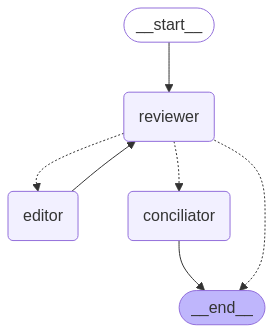

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
text = "The quick brown fox jump over the lazy dog."
initial_state = WorkflowState(text=text,edited_text=text)
final_state = graph.invoke(initial_state)
final_state = WorkflowState(**final_state)
print(final_state.edited_text)
print(history_to_str(final_state.history))